# Session Analysis

In [1]:
import pandas as pd
import dask.dataframe as ddf
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PowerTransformer
import helper_fns
%matplotlib inline

# Initial data exploration

In [2]:
df = ddf.read_csv('session_data_v2.csv')
df.head()

,sess_id,rtt_ms,engaged,conv_val,conv_cnt,conv_rate,start_hour,user,loyalty,loyal,...,os_id,refer_catg,refer_catg_id,refer_subCatg,refer_subCatg_id,pg_count,hit_evnt_cnt,hit_evnt_clicks,hit_evnt_forms,hit_evnt_ajax
0,4347814,100.0,True,0,0,NaN,23,4337070,1,False,...,8,Link,7,NaN,42,1,12,1,1,4
1,4347831,50.0,True,0,0,NaN,23,4337087,1,False,...,12,Search,6,yahoo.com,38,1,11,1,1,3
2,4347833,50.0,True,0,0,NaN,23,4337089,1,False,...,15,Social,5,facebook.com,17,1,8,1,1,4
3,4347837,100.0,True,0,0,NaN,23,4337093,1,False,...,8,Social,5,instagram.com,19,1,8,1,1,2
4,4347838,100.0,True,0,0,NaN,23,4337094,1,False,...,8,Social,5,instagram.com,19,1,11,1,1,3


In [3]:
df.columns

Index(['sess_id', 'rtt_ms', 'engaged', 'conv_val', 'conv_cnt', 'conv_rate',
       'start_hour', 'user', 'loyalty', 'loyal', 'country_iso_code', 'lat',
       'long', 'device_name', 'device_id', 'browser', 'browser_id', 'os_name',
       'os_id', 'refer_catg', 'refer_catg_id', 'refer_subCatg',
       'refer_subCatg_id', 'pg_count', 'hit_evnt_cnt', 'hit_evnt_clicks',
       'hit_evnt_forms', 'hit_evnt_ajax'],
      dtype='object')

In [4]:
df.compute().shape

(2414594, 28)

In [5]:
print('{} unique country codes: {}'.format(len(df.country_iso_code.compute().unique()), df.country_iso_code.compute().unique()))
print('{} unique browser ids: {}'.format(len(df.browser.compute().unique()), df.browser.compute().unique()))
print('{} unique os ids: {}'.format(len(df.os_name.compute().unique()), df.os_name.compute().unique()))
print('{} unique device names: {}'.format(len(df.device_name.compute().unique()), df.device_name.compute().unique()))
print('{} unique referral categories: {}'.format(len(df.refer_catg.compute().unique()), df.refer_catg.compute().unique()))
print('{} unique referral SubCategories: {}'.format(len(df.refer_subCatg.compute().unique()), df.refer_subCatg.compute().unique()))

19 unique country codes: ['US' 'RU' 'DE' 'GB' 'FR' 'IN' 'EG' 'IL' 'IE' 'CA' 'CR' 'UA' 'BR' 'GR'
 'CH' 'PK' 'SE' 'CO' 'FI']
70 unique browser ids: ['Chrome' 'Safari' 'Flipboard App' 'Opera Mobile' 'Google App'
 'Samsung Browser' 'IE' 'Silk' 'Edge' 'Apple Mail' 'UC Browser' 'AliApp'
 'Opera' 'Facebook App' 'Sogou Explorer' 'Yandex Browser'
 'Android WebView' 'Chromium' 'Firefox for iOS' 'Maxthon'
 'Default Browser' 'Vivaldi' 'Whale Browser' 'Splash' 'Iron'
 'Facebook Messenger' 'Firefox' 'Vivo Browser' 'Mobile Safari UIWebView'
 'QQBrowser' 'Dragon' 'liebao' 'Yandex' 'Headless Chrome'
 'Coc Coc Browser' 'BingPreview' 'Google Lighthouse' 'safari' 'chrome'
 'edge' 'samsung browser' 'opera mobile' 'silk' 'ie' 'opera' 'aliapp'
 'chromium' 'vivaldi' 'kuaiso' 'sklikbot' 'feedhub' 'Kuaiso' 'w3clinemode'
 'LinkedInBot' 'SklikBot' 'Desktop Sidebar' 'Nokia Proxy Browser' 'mozdex'
 'apusbrowser' 'webringchecker' 'linkedinbot' 'newsarticle app'
 'magpie-crawler' 'APUSBrowser' 'juzi browser'
 'php br

# Select columns we want to use

In [6]:
# not choosing rtt_ms b.c. it has too many NaNs, not choosing engaged because it only has 1 value
subset_df = df[['conv_rate', 'start_hour', 'loyalty', 'loyal', 'country_iso_code', 'device_name', 'browser', 'os_name', 'refer_catg', 'refer_subCatg', 'pg_count', 'hit_evnt_cnt', 'hit_evnt_clicks', 'hit_evnt_forms', 'hit_evnt_ajax']]
subset_df.head()

,conv_rate,start_hour,loyalty,loyal,country_iso_code,device_name,browser,os_name,refer_catg,refer_subCatg,pg_count,hit_evnt_cnt,hit_evnt_clicks,hit_evnt_forms,hit_evnt_ajax
0,NaN,23,1,False,US,iPad,Chrome,NaN,Link,NaN,1,12,1,1,4
1,NaN,23,1,False,US,Macintosh,Chrome,macOS,Search,yahoo.com,1,11,1,1,3
2,NaN,23,1,False,US,Windows Desktop,Chrome,Windows 8.1,Social,facebook.com,1,8,1,1,4
3,NaN,23,1,False,US,iPad,Safari,NaN,Social,instagram.com,1,8,1,1,2
4,NaN,23,1,False,US,iPhone,Chrome,NaN,Social,instagram.com,1,11,1,1,3


In [7]:
subset_df.compute().shape

(2414594, 15)

# Initial data cleanup

In [8]:
# set converion rates to 0 if originally NaN
subset_df['conv_rate'] = subset_df['conv_rate'].fillna(0)
subset_df = subset_df.compute()
# drop NANs
subset_df = subset_df.dropna()
subset_df.reset_index(inplace=True, drop=True)

## noticing some redundancies in OS types so need to lowercase
subset_df['os_name'] = subset_df.os_name.apply(lambda x: x.lower())
subset_df['device_name'] = subset_df.device_name.apply(lambda x: x.lower())
subset_df['browser'] = subset_df.browser.apply(lambda x: x.lower())
subset_df['refer_catg'] = subset_df.refer_catg.apply(lambda x: x.lower())
subset_df['refer_subCatg'] = subset_df.refer_subCatg.apply(lambda x: x.lower())

# convert booleans to numerical
subset_df['loyal'] = subset_df.loyal.astype(int)

subset_df.head()

,conv_rate,start_hour,loyalty,loyal,country_iso_code,device_name,browser,os_name,refer_catg,refer_subCatg,pg_count,hit_evnt_cnt,hit_evnt_clicks,hit_evnt_forms,hit_evnt_ajax
0,0.0,23,1,0,US,macintosh,chrome,macos,search,yahoo.com,1,11,1,1,3
1,0.0,23,1,0,US,windows desktop,chrome,windows 8.1,social,facebook.com,1,8,1,1,4
2,0.0,23,1,0,US,linux desktop,chrome,linux,search,google.com,1,6,1,1,3
3,0.0,23,1,0,US,macintosh,chrome,macos,social,pinterest.com,1,6,1,1,2
4,0.0,23,1,0,US,macintosh,chrome,macos,search,baidu.com,1,5,1,1,3


In [9]:
subset_df.shape

(1435733, 15)

# Understand how Real-valued data is distibuted

In [10]:
subset_df.describe()

,conv_rate,start_hour,loyalty,loyal,pg_count,hit_evnt_cnt,hit_evnt_clicks,hit_evnt_forms,hit_evnt_ajax
count,1.435733e+06,1.435733e+06,1.435733e+06,1.435733e+06,1.435733e+06,1.435733e+06,1.435733e+06,1.435733e+06,1.435733e+06
mean,4.512901e+03,1.209896e+01,1.121039e+00,5.479222e-02,5.554950e+00,2.306046e+01,1.630660e+01,6.060232e+00,1.203214e+01
std,2.323651e+04,6.864304e+00,3.092361e+00,2.275743e-01,3.918382e+00,1.523124e+01,1.596434e+01,4.491721e+00,7.472736e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,0.000000e+00,6.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,7.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00
50%,0.000000e+00,1.300000e+01,1.000000e+00,0.000000e+00,5.000000e+00,2.500000e+01,1.300000e+01,5.000000e+00,1.300000e+01
75%,0.000000e+00,1.800000e+01,1.000000e+00,0.000000e+00,9.000000e+00,3.400000e+01,2.700000e+01,1.000000e+01,1.700000e+01
max,3.309960e+05,2.300000e+01,2.910000e+02,1.000000e+00,2.500000e+01,1.090000e+02,1.350000e+02,2.700000e+01,6.000000e+01


<AxesSubplot:xlabel='hit_evnt_ajax', ylabel='Density'>

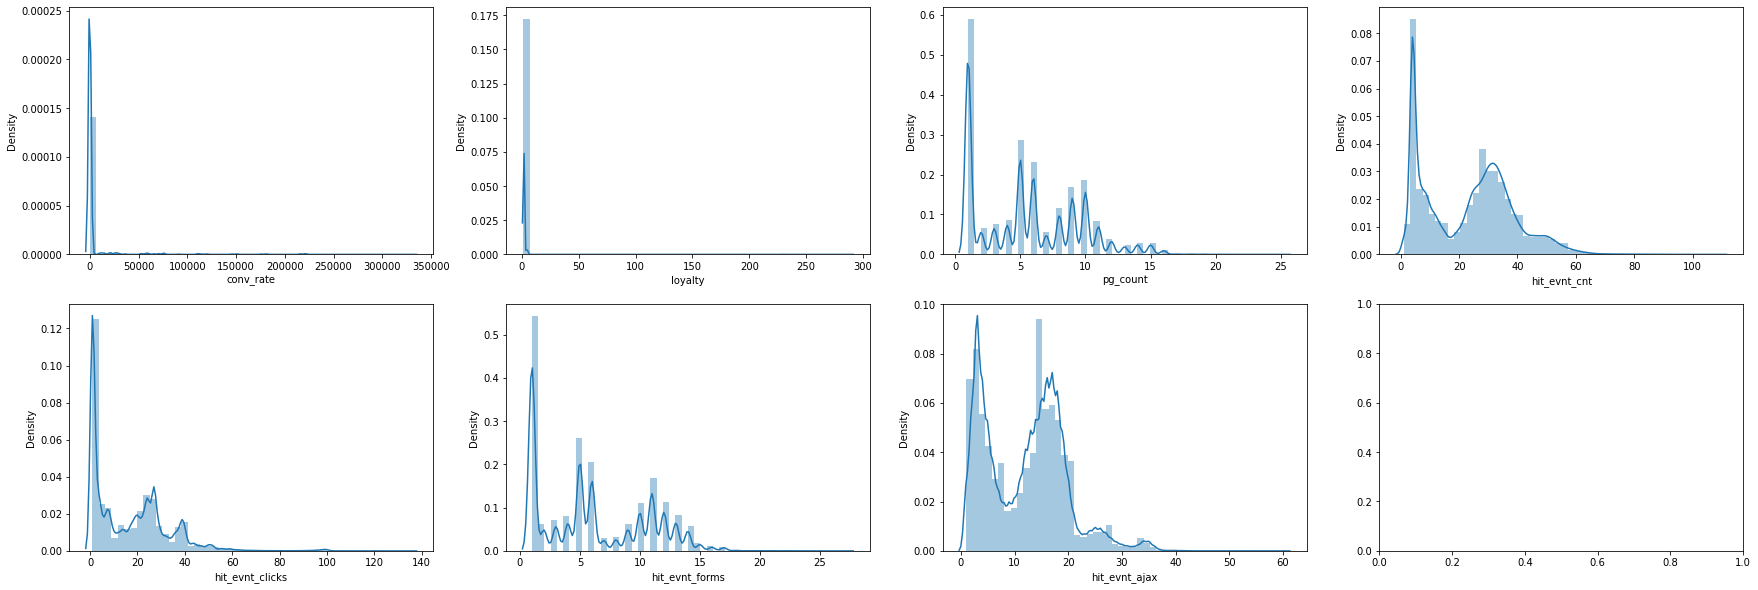

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(30,10))

sbn.distplot(subset_df.conv_rate, ax=axs[0,0])
sbn.distplot(subset_df.loyalty, ax=axs[0,1])
sbn.distplot(subset_df.pg_count, ax=axs[0,2])
sbn.distplot(subset_df.hit_evnt_cnt, ax=axs[0,3])
sbn.distplot(subset_df.hit_evnt_clicks, ax=axs[1,0])
sbn.distplot(subset_df.hit_evnt_forms, ax=axs[1,1])
sbn.distplot(subset_df.hit_evnt_ajax, ax=axs[1,2])


# Power Transform and Normalize data

In [11]:
# due to non gaussian distributions, need to transform that data to be more gaussian
pwr_trsfrm = PowerTransformer()
normalized_data = pwr_trsfrm.fit_transform(subset_df[['conv_rate', 'loyalty', 'pg_count', 'hit_evnt_cnt', 'hit_evnt_clicks', 'hit_evnt_forms', 'hit_evnt_ajax']])
normalized_df = pd.DataFrame(normalized_data, columns=['conv_rate', 'loyalty', 'pg_count', 'hit_evnt_cnt', 'hit_evnt_clicks', 'hit_evnt_forms', 'hit_evnt_ajax'])
normalized_df.head()

,conv_rate,loyalty,pg_count,hit_evnt_cnt,hit_evnt_clicks,hit_evnt_forms,hit_evnt_ajax
0,-0.262246,-0.240792,-1.328991,-0.673618,-1.28356,-1.31504,-1.315113
1,-0.262246,-0.240792,-1.328991,-0.949226,-1.28356,-1.31504,-1.099848
2,-0.262246,-0.240792,-1.328991,-1.159924,-1.28356,-1.31504,-1.315113
3,-0.262246,-0.240792,-1.328991,-1.159924,-1.28356,-1.31504,-1.559321
4,-0.262246,-0.240792,-1.328991,-1.276792,-1.28356,-1.31504,-1.315113


<AxesSubplot:xlabel='hit_evnt_ajax', ylabel='Density'>

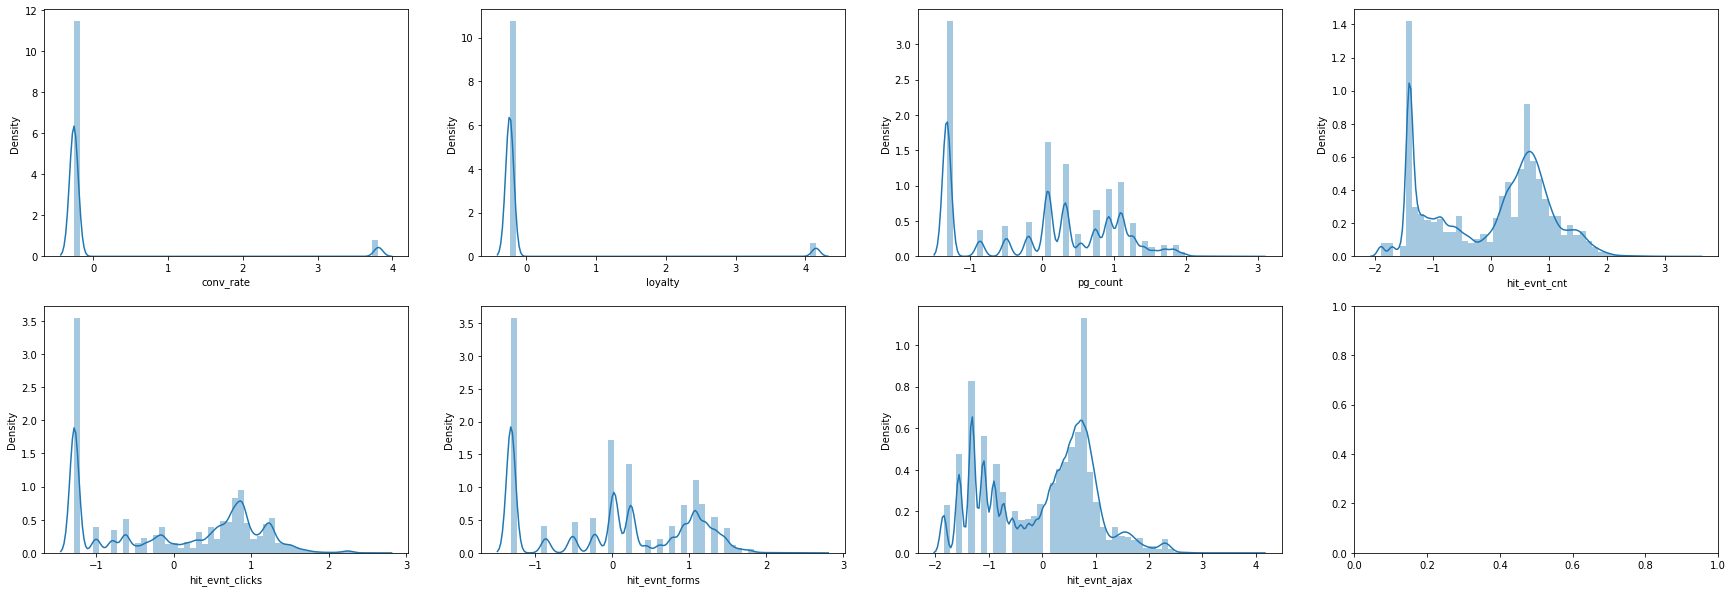

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(30,10))

sbn.distplot(normalized_df.conv_rate, ax=axs[0,0])
sbn.distplot(normalized_df.loyalty, ax=axs[0,1])
sbn.distplot(normalized_df.pg_count, ax=axs[0,2])
sbn.distplot(normalized_df.hit_evnt_cnt, ax=axs[0,3])
sbn.distplot(normalized_df.hit_evnt_clicks, ax=axs[1,0])
sbn.distplot(normalized_df.hit_evnt_forms, ax=axs[1,1])
sbn.distplot(normalized_df.hit_evnt_ajax, ax=axs[1,2])


In [12]:
# rejoin data to new normalized data
slimmed_df = subset_df.drop(columns=['conv_rate', 'loyalty', 'pg_count', 'hit_evnt_cnt', 'hit_evnt_clicks', 'hit_evnt_forms', 'hit_evnt_ajax'])
new_normalized_df = slimmed_df.join(normalized_df)
new_normalized_df.head()

,start_hour,loyal,country_iso_code,device_name,browser,os_name,refer_catg,refer_subCatg,conv_rate,loyalty,pg_count,hit_evnt_cnt,hit_evnt_clicks,hit_evnt_forms,hit_evnt_ajax
0,23,0,US,macintosh,chrome,macos,search,yahoo.com,-0.262246,-0.240792,-1.328991,-0.673618,-1.28356,-1.31504,-1.315113
1,23,0,US,windows desktop,chrome,windows 8.1,social,facebook.com,-0.262246,-0.240792,-1.328991,-0.949226,-1.28356,-1.31504,-1.099848
2,23,0,US,linux desktop,chrome,linux,search,google.com,-0.262246,-0.240792,-1.328991,-1.159924,-1.28356,-1.31504,-1.315113
3,23,0,US,macintosh,chrome,macos,social,pinterest.com,-0.262246,-0.240792,-1.328991,-1.159924,-1.28356,-1.31504,-1.559321
4,23,0,US,macintosh,chrome,macos,search,baidu.com,-0.262246,-0.240792,-1.328991,-1.276792,-1.28356,-1.31504,-1.315113


# Encode categorical data with OneHot encodings

In [13]:
new_normalized_df = helper_fns.perform_one_hot_encoding(new_normalized_df, 'country_iso_code')
new_normalized_df = helper_fns.perform_one_hot_encoding(new_normalized_df, 'device_name')
new_normalized_df = helper_fns.perform_one_hot_encoding(new_normalized_df, 'browser')
new_normalized_df = helper_fns.perform_one_hot_encoding(new_normalized_df, 'refer_catg')
new_normalized_df = helper_fns.perform_one_hot_encoding(new_normalized_df, 'refer_subCatg')
new_normalized_df = new_normalized_df.drop(columns=['os_name', 'country_iso_code', 'device_name', 'browser', 'refer_catg', 'refer_subCatg'])

new_normalized_df.head()

,start_hour,loyal,conv_rate,loyalty,pg_count,hit_evnt_cnt,hit_evnt_clicks,hit_evnt_forms,hit_evnt_ajax,"(BR,)",...,"(social,)","(ask.com,)","(baidu.com,)","(bing.com,)","(duckduckgo.com,)","(facebook.com,)","(google.com,)","(instagram.com,)","(pinterest.com,)","(yahoo.com,)"
0,23,0,-0.262246,-0.240792,-1.328991,-0.673618,-1.28356,-1.31504,-1.315113,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,23,0,-0.262246,-0.240792,-1.328991,-0.949226,-1.28356,-1.31504,-1.099848,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,23,0,-0.262246,-0.240792,-1.328991,-1.159924,-1.28356,-1.31504,-1.315113,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,23,0,-0.262246,-0.240792,-1.328991,-1.159924,-1.28356,-1.31504,-1.559321,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,23,0,-0.262246,-0.240792,-1.328991,-1.276792,-1.28356,-1.31504,-1.315113,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
new_normalized_df.shape

(1435733, 73)

# Save dataset for future, more efficient, model development and analysis

In [17]:
new_normalized_df.to_csv('session_data_v2_cleaned.csv', index=False)